In [23]:
import numpy as np
import pandas as pd 
import os
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image, display

# Data Exploration

In [16]:
# Define dataset paths (assuming the dataset is in the same directory)
# The dataset has JPEGImages for images and Annotations_txt for YOLO-formatted labels.
base_path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/'
images_path = os.path.join(base_path, 'JPEGImages')
annotations_path = os.path.join(base_path, 'Annotations_txt')

# The class names are provided in the dataset description
class_names = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']

In [6]:
def plot_bounding_boxes(image_path, annotation_path, class_names):
    """
    Plots bounding boxes on an image.
    The annotations are in YOLO format (normalized coordinates).
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Read the annotations
    with open(annotation_path, 'r') as f:
        annotations = f.readlines()

    # Draw bounding boxes
    for ann in annotations:
        parts = ann.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert normalized coordinates to pixel coordinates
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Draw the rectangle and label
        color = tuple(random.randint(0, 255) for _ in range(3))
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, class_names[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

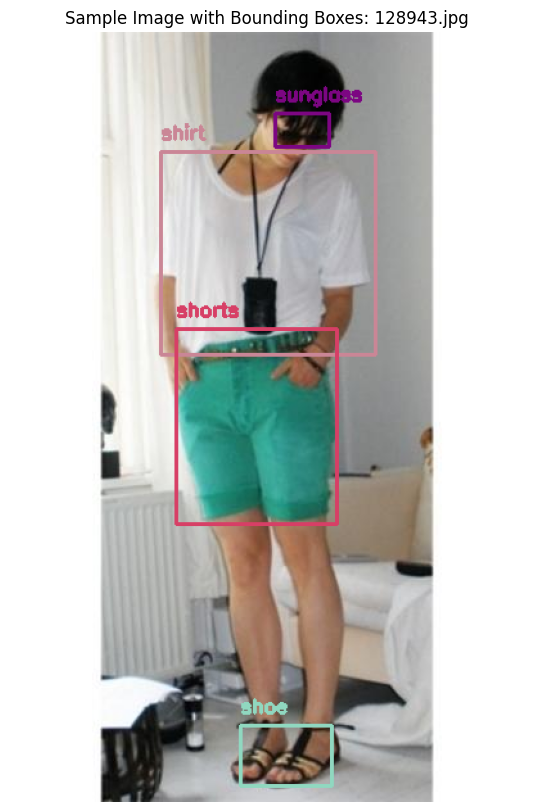

In [7]:

# Get a list of all images
all_images = os.listdir(images_path)
random_image_file = random.choice(all_images)
random_image_name = os.path.splitext(random_image_file)[0]

# Get the corresponding annotation file
image_path = os.path.join(images_path, random_image_file)
annotation_path = os.path.join(annotations_path, random_image_name + '.txt')

# Plot the image with bounding boxes
if os.path.exists(annotation_path):
    plotted_image = plot_bounding_boxes(image_path, annotation_path, class_names)
    plt.figure(figsize=(10, 10))
    plt.imshow(plotted_image)
    plt.title(f"Sample Image with Bounding Boxes: {random_image_file}")
    plt.axis('off')
    plt.show()
else:
    print(f"No annotation file found for {random_image_file}")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


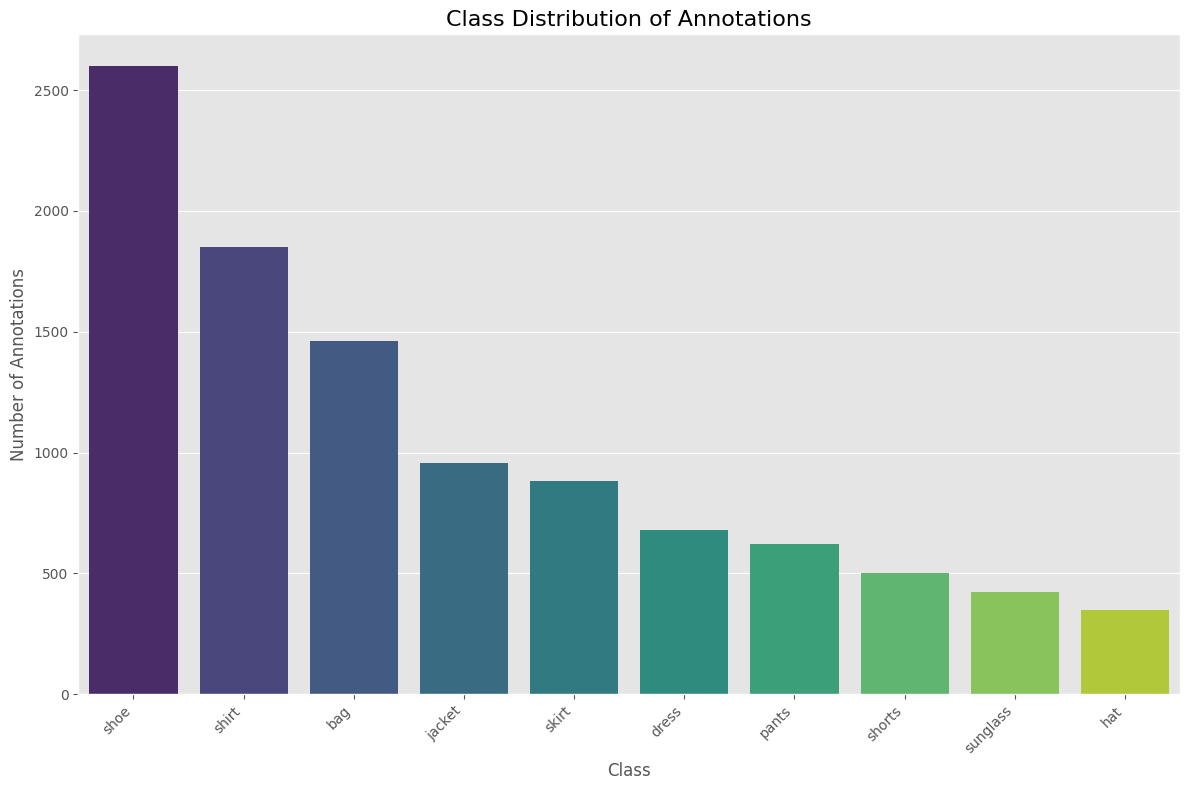

Total annotations found: 10333
Class distribution:
  - shoe: 2601
  - shirt: 1852
  - bag: 1462
  - jacket: 958
  - skirt: 883
  - dress: 678
  - pants: 622
  - shorts: 502
  - sunglass: 425
  - hat: 350


In [19]:
class_counts = Counter()
total_annotations = 0

# Iterate through all annotation files
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        filepath = os.path.join(annotations_path, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if parts:
                    try:
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
                        total_annotations += 1
                    except(ValueError, IndexError):
                        continue

# Check if any annotations were found
if total_annotations == 0:
    print("No annotations found. Please check the dataset path and format.")
else:
    # Map class IDs to class names
    class_labels = {idx: name for idx, name in enumerate(class_names)}
    labeled_counts = {class_labels[k]: v for k, v in class_counts.items()}
    sorted_counts = dict(sorted(labeled_counts.items(), key=lambda item: item[1], reverse=True))

    # Plot the class distribution
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), palette='viridis')
    plt.title('Class Distribution of Annotations', fontsize=16)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Annotations', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()

    print(f"Total annotations found: {total_annotations}")
    print("Class distribution:")
    for name, count in sorted_counts.items():
        print(f"  - {name}: {count}")


# Training the Model (YOLO)

In [3]:
#!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [5]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.6.0+cu124 (Tesla P100-PCIE-16GB)


In [7]:
# load pre-trained model
detection_model = YOLO("yolov8m.pt")

### Split Data into Train and Test

In [ ]:
os.mkdir('train')
os.mkdir('train/images')
os.mkdir('train/labels')

os.mkdir('test')
os.mkdir('test/images')
os.mkdir('test/labels')

In [10]:
yolo_data_path = '/kaggle/working'
train_path = '/kaggle/working/train/'
test_path = '/kaggle/working/test/'

In [11]:
# Get a list of all image filenames
image_files = os.listdir(images_path)
image_filenames = [os.path.splitext(f)[0] for f in image_files if f.endswith('.jpg')]

# Split the dataset into training and validation sets
train_filenames, val_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)

In [18]:
# Copy files to the new directory structure
for filename in train_filenames:
    shutil.copy(os.path.join(images_path, filename + '.jpg'), os.path.join(yolo_data_path, 'train', 'images'))
    shutil.copy(os.path.join(annotations_path, filename + '.txt'), os.path.join(yolo_data_path, 'train', 'labels'))

for filename in val_filenames:
    shutil.copy(os.path.join(images_path, filename + '.jpg'), os.path.join(yolo_data_path, 'test', 'images'))
    shutil.copy(os.path.join(annotations_path, filename + '.txt'), os.path.join(yolo_data_path, 'test', 'labels'))

print("Dataset split and organized successfully.")

Dataset split and organized successfully.


Create yaml file

In [19]:
text = """
train: /kaggle/working/train
val: /kaggle/working/test

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [22]:
# Trained on Kaggle with P100 GPU
model =  YOLO("yolov8m.pt")

model.train(data='data.yaml', epochs = 20)

Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, 

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 876.5±239.6 MB/s, size: 31.7 KB)


train: Scanning /kaggle/working/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 1390.98it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 741.4±558.5 MB/s, size: 48.9 KB)


val: Scanning /kaggle/working/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 843.30it/s]


val: New cache created: /kaggle/working/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.84G      1.301      1.829      1.426          3        640: 100%|██████████| 135/135 [01:25<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.78it/s]

                   all        537       2041      0.721      0.686      0.712      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.91G      1.272      1.235       1.39          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]

                   all        537       2041      0.582      0.654      0.652      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.98G       1.27      1.216      1.403          9        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]

                   all        537       2041      0.698      0.667      0.702      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.15G      1.254      1.168      1.385         15        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]

                   all        537       2041      0.648      0.672      0.667      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.38G      1.226      1.112      1.371          6        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2041      0.735      0.662      0.695      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.37G      1.209      1.064      1.362          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        537       2041      0.654      0.735      0.734      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.25G      1.178     0.9942      1.339          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]

                   all        537       2041      0.676       0.72      0.731      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.15G       1.17     0.9917      1.325          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]

                   all        537       2041        0.7      0.766      0.764      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.38G       1.15     0.9561      1.328          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]

                   all        537       2041      0.723       0.76      0.767      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.38G       1.13     0.9088      1.301          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        537       2041      0.744      0.745      0.768      0.506


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.25G      1.073     0.8343      1.291          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        537       2041      0.735      0.744      0.762      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.15G      1.064     0.8072      1.286          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]

                   all        537       2041       0.74       0.73      0.771      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.39G      1.035      0.769      1.259          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]

                   all        537       2041      0.757      0.766      0.786       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.38G      1.023     0.7391      1.262          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        537       2041      0.736      0.763      0.789      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.45G     0.9845     0.6901      1.231          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        537       2041      0.756      0.768      0.784      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.15G      0.969     0.6684       1.22          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]

                   all        537       2041       0.74      0.776       0.78      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.39G     0.9405     0.6272      1.199          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]

                   all        537       2041      0.742      0.774      0.779      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.38G      0.912     0.5944      1.178          2        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]

                   all        537       2041      0.753      0.776      0.789      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.24G     0.9049     0.5776      1.175          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]

                   all        537       2041       0.74      0.792      0.791      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.15G     0.8767     0.5518      1.161          5        640: 100%|██████████| 135/135 [01:22<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]

                   all        537       2041      0.745      0.796      0.792       0.55



20 epochs completed in 0.500 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        537       2041      0.739      0.798      0.792       0.55
              sunglass         80         80      0.572        0.3      0.395      0.127
                   hat         77         77      0.757      0.805      0.787      0.463
                jacket        169        170      0.652      0.865      0.828       0.67
                 shirt        363        366      0.811      0.893      0.895      0.639
                 pants        137        137       0.93      0.956      0.972        0.8
                shorts         98         98      0.682      0.786      0.713      0.492
                 skirt        156        156      0.709      0.872      0.818      0.659
                 dress        148        148      0.796      0.858      0.869      0.687
                   bag        286        286      0.744      0.822      0.822      0.474
                  shoe        523        523       0.74       0.82      0.816      0.489
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c7e647be290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

Displaying training graphs from the results directory:
--- Training Metrics over Epochs ---


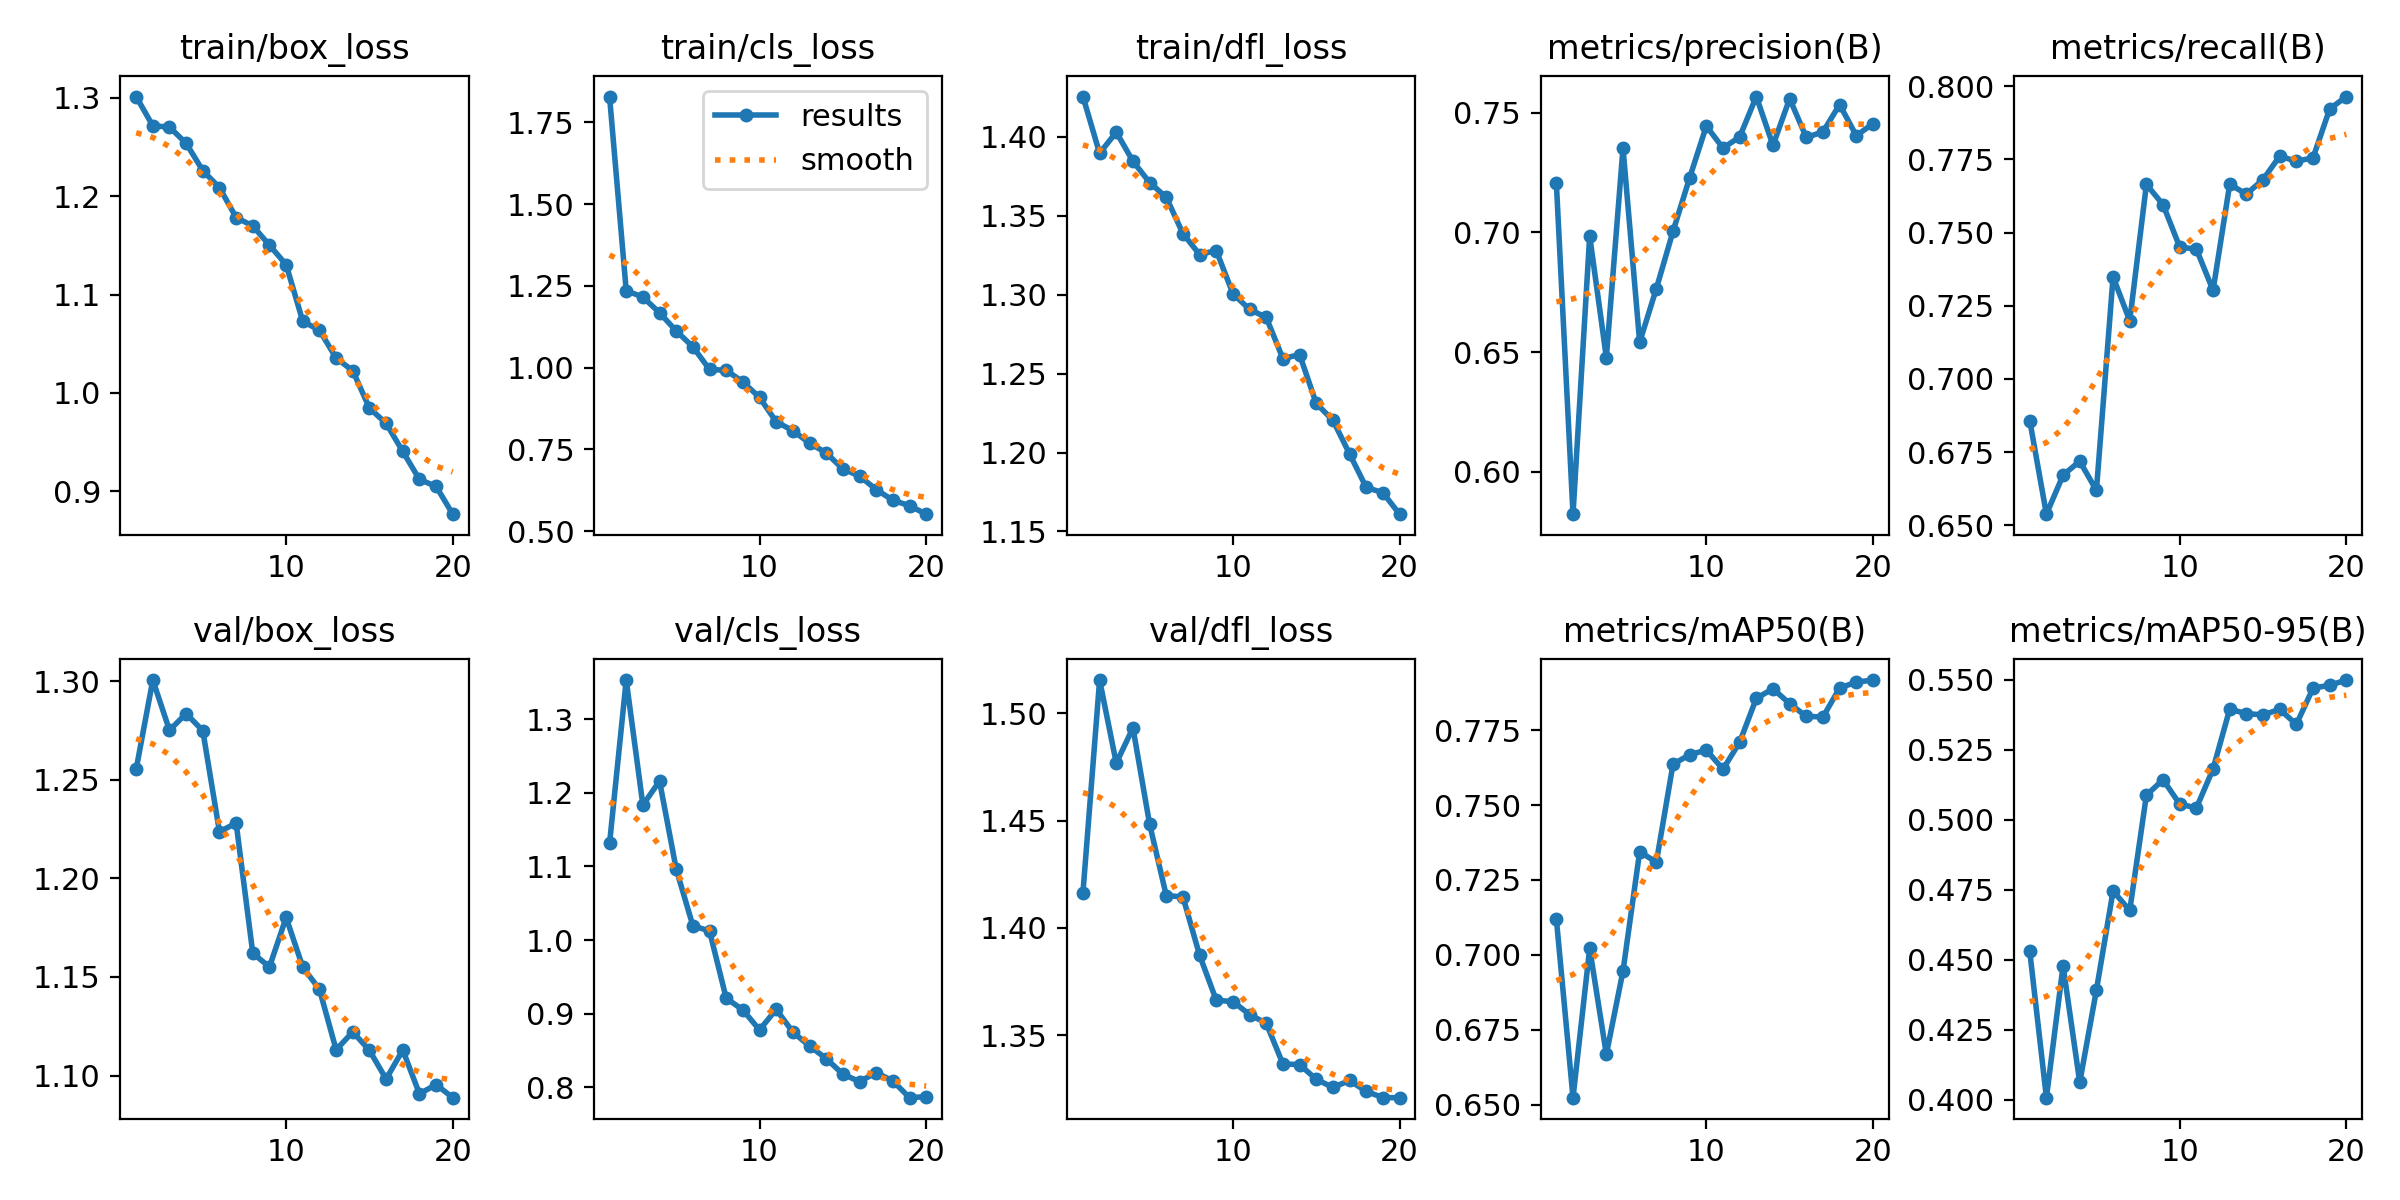


--- Confusion Matrix ---


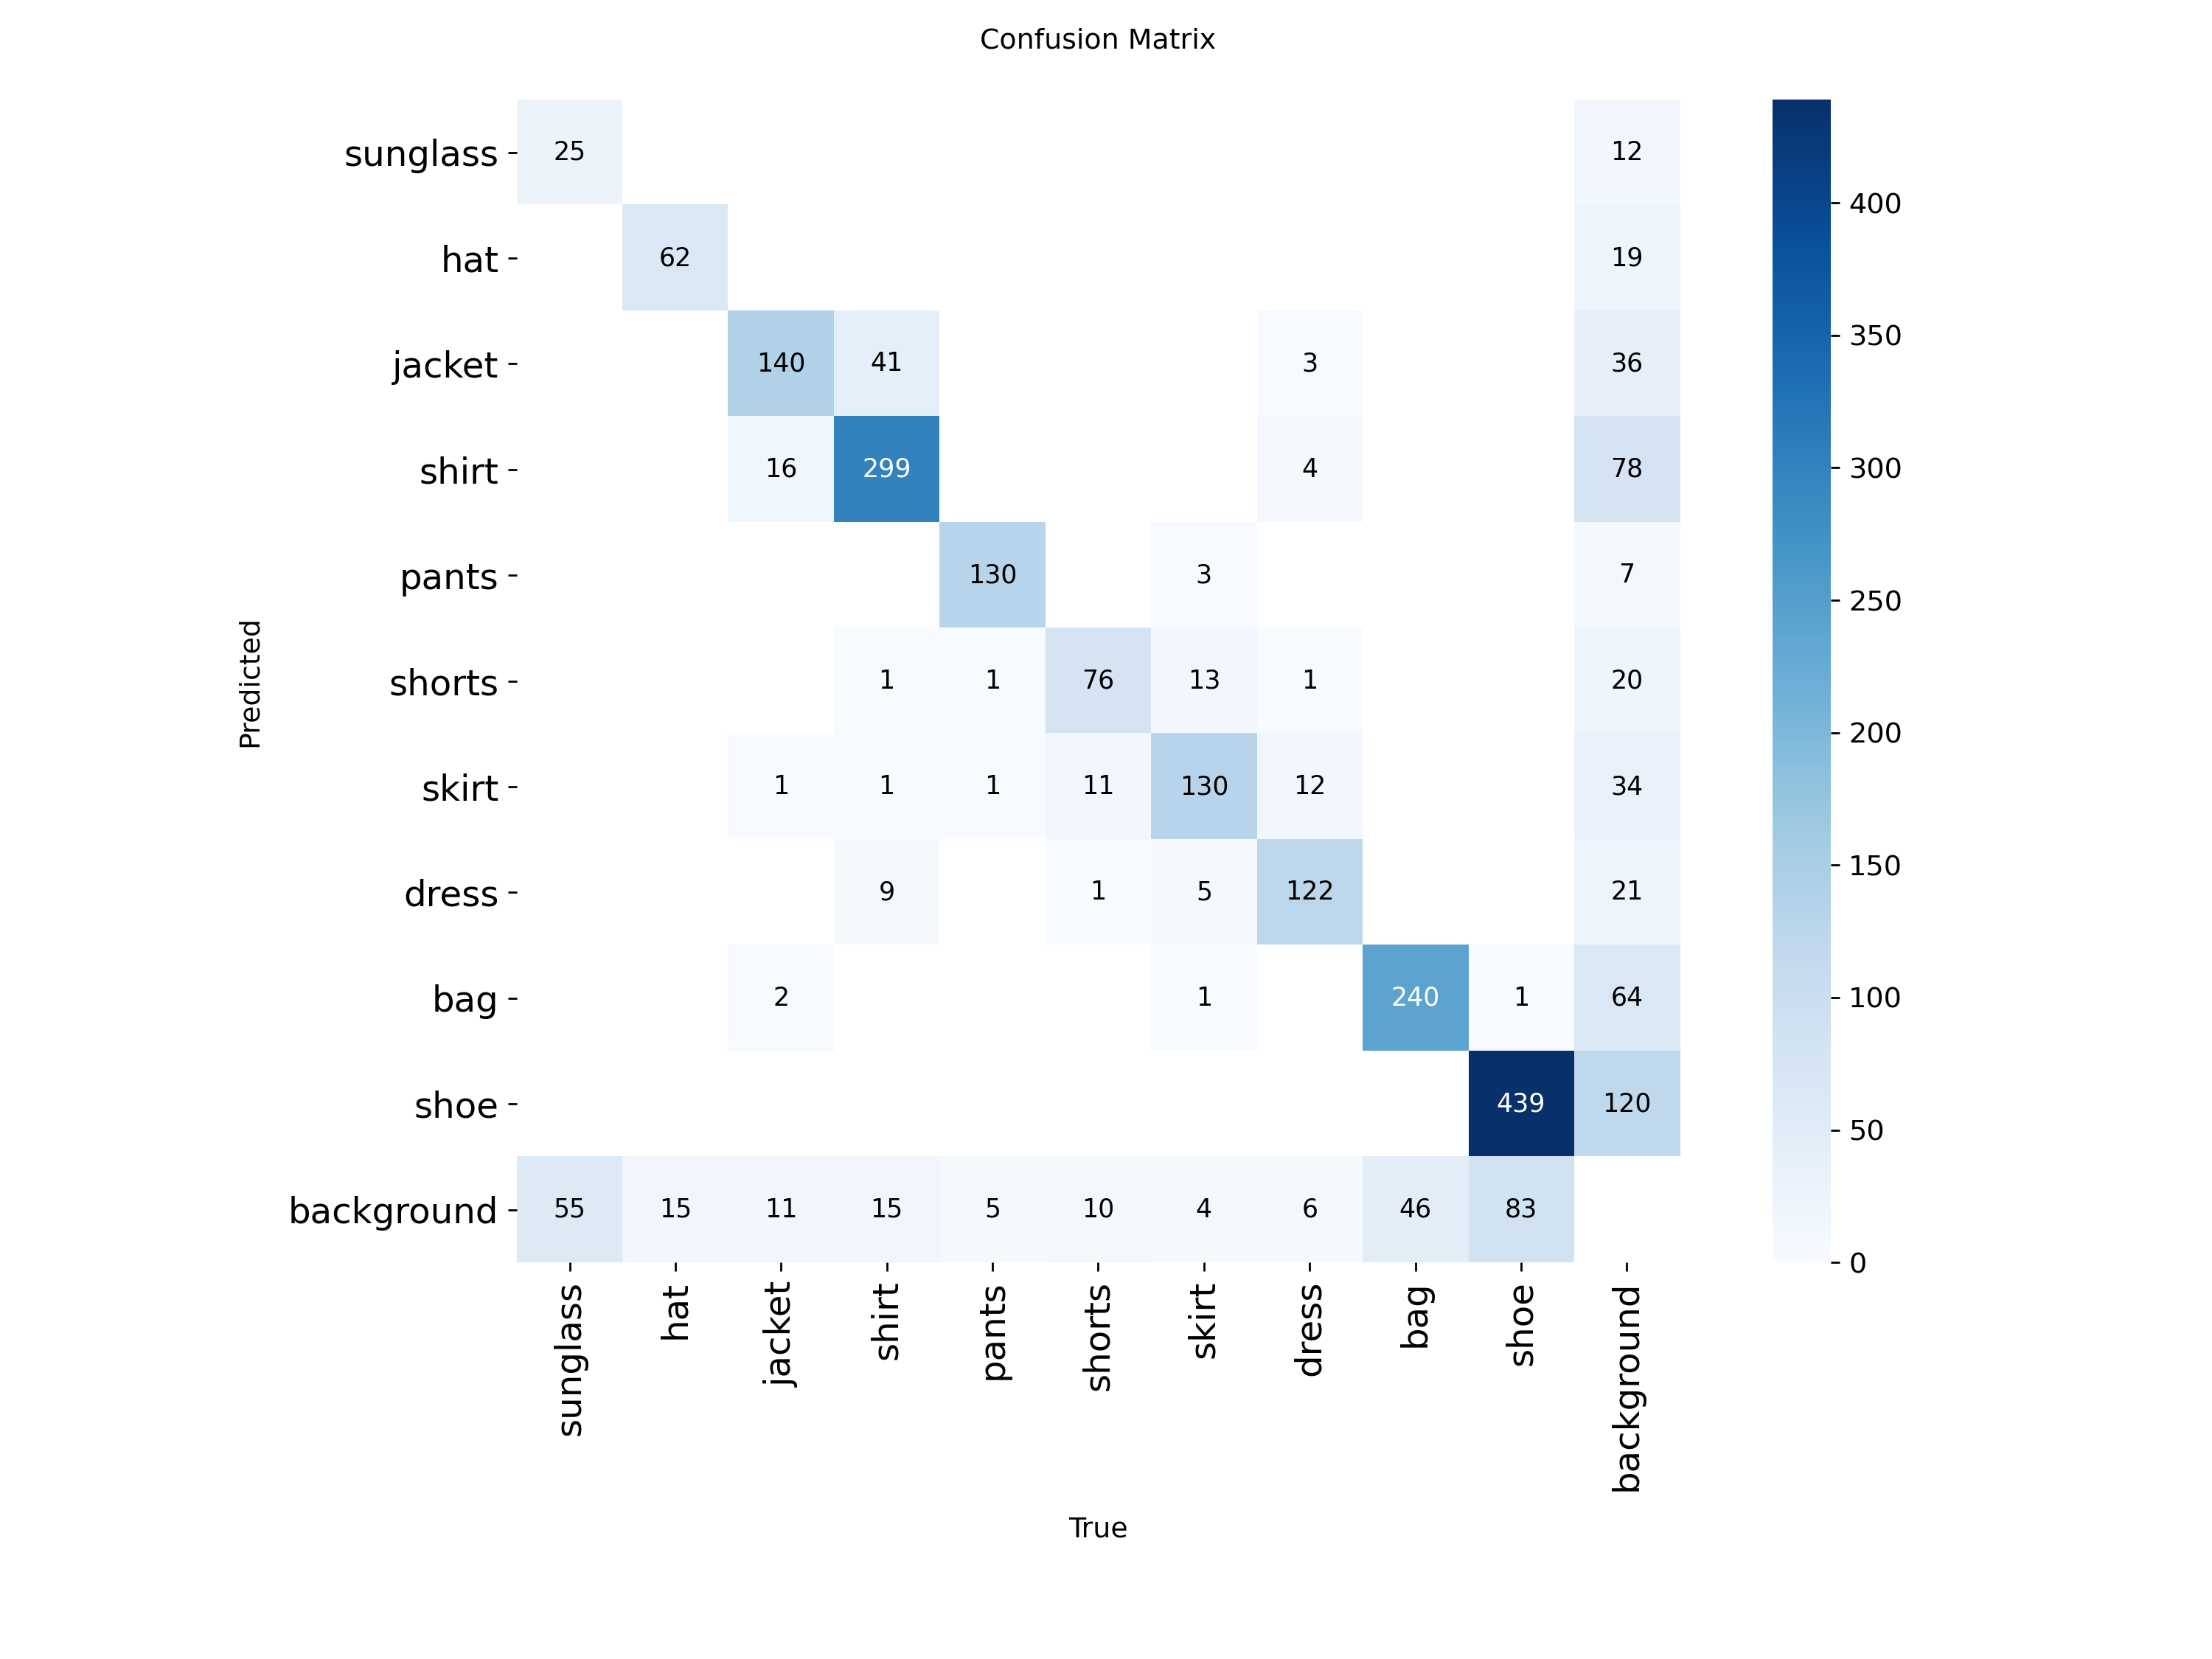

In [25]:
# Define the path to the training results directory
results_dir = '/kaggle/working/runs/detect/train'

# Define the filenames of the graphs you want to display
results_plot_path = os.path.join(results_dir, 'results.png')
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')

# Display the images if they exist
print("Displaying training graphs from the results directory:")

if os.path.exists(results_plot_path):
    print("--- Training Metrics over Epochs ---")
    display(Image(filename=results_plot_path))
else:
    print(f"Error: The file '{results_plot_path}' was not found. Please check your path.")

if os.path.exists(confusion_matrix_path):
    print("\n--- Confusion Matrix ---")
    display(Image(filename=confusion_matrix_path))
else:
    print(f"Error: The file '{confusion_matrix_path}' was not found. Please check your path.")



image 1/1 /kaggle/working/test/images/67678.jpg: 640x448 1 shirt, 1 skirt, 41.1ms
Speed: 2.2ms preprocess, 41.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /kaggle/working/test/images/183145.jpg: 640x448 1 jacket, 1 shirt, 1 skirt, 1 bag, 1 shoe, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /kaggle/working/test/images/190622.jpg: 640x448 2 shirts, 1 shorts, 1 bag, 1 shoe, 13.0ms
Speed: 1.7ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /kaggle/working/test/images/46812.jpg: 640x448 1 shirt, 1 skirt, 1 bag, 1 shoe, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


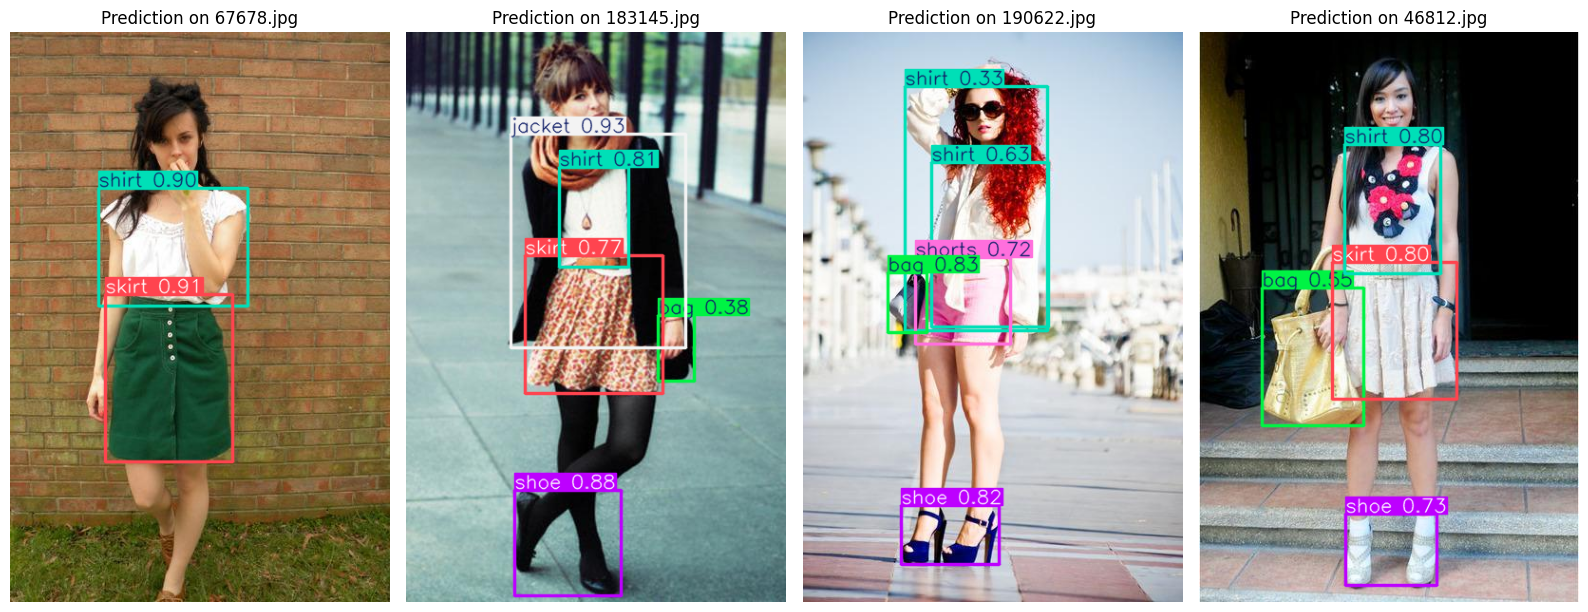

In [27]:
val_images_path = '/kaggle/working/test/images'

# Get a list of all validation image filenames
val_image_files = os.listdir(val_images_path)

# Select a few random images (e.g., 4)
random_images = random.sample(val_image_files, min(4, len(val_image_files)))

# Visualize predictions on the random images
fig, axes = plt.subplots(1, len(random_images), figsize=(16, 6))

if len(random_images) == 1:
    axes = [axes] # Ensure axes is iterable for a single image

for i, image_file in enumerate(random_images):
    image_path = os.path.join(val_images_path, image_file)
    
    # Run inference on the image
    results = model.predict(image_path)
    
    # The 'plot()' method draws bounding boxes and labels directly on the image
    plotted_image = results[0].plot()
    
    axes[i].imshow(plotted_image[..., ::-1])  # Convert BGR to RGB for matplotlib
    axes[i].set_title(f"Prediction on {image_file}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
